# Classification for the centar of mass $(r_\text{cm})$ of exoplanetary systems through GMM 

We use Gaussian Mixture Model to clasify the center of mass of exoplanetary systems, employing the observational data  

## 1. Read and clean the file from exoplanet.eu

From the most complete list of observed exoplanets planets to date, <a href="http://exoplanet.eu/">exoplanet.eu</a>, we take the planetary mass $M_{tp}$, the semi_major $a$ and the Metallicity Fe/H (with their respective uncertainties).  

It is necessary processing the data with the prurpose to obtain the Center of Mass $r_\text{cm}$, as a DataFrame `data`, without NaN values in the columns of _mass_ ($M_{tp}$) and _semi major axis_($a$). Finally, we get the data cleaned.

**Remember**: `pd.notnull("name_of_column")` deletes the NaN values in the column. 

**Remember**: `data=data[['column_a','column_b',..,'column_n',]]` to get a new order in the DataFrame

In [20]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
import pandas as pd; 
import numpy as np
from scipy.stats import norm 
import random
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt 
import seaborn as sb
from matplotlib import rc, cm, rcParams

rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
rc('text', usetex=True)
%matplotlib inline

Now, the data is read (only mass and semi major axis with their uncertainties).

In [3]:
data_ep = pd.read_csv('data/exoplanet.eu_catalog.csv', 
                      usecols=['mass','mass_error_min','semi_major_axis',
                               'semi_major_axis_error_min','star_name'])

# It replaces the inf values:
data_ep = data_ep.replace([np.inf, -np.inf], np.nan) 

# Total of NaN values:
print("Total of NaN values = "+str(data_ep.isnull().sum().sum()))

# Numer of nan values per column:
data_ep.isnull().sum()

Total of NaN values = 8485


mass                         2158
mass_error_min               2369
semi_major_axis              1476
semi_major_axis_error_min    2477
star_name                       5
dtype: int64

After check for missing values in the data, we can see that some names of stars do not exists!!<font color='red'> Does it mean that some stars do not have names?</font> We will discuss latter. 

For the time being, we are going to continue cleaning the data. We do not take into account the NaN values.

In [4]:
dataB = data_ep.dropna(subset=['mass','mass_error_min','semi_major_axis',
                               'semi_major_axis_error_min'])

# Clean the data for the star names:
dataB = dataB.dropna(subset=['star_name'])

# Data after cleaning:
data = dataB[['star_name','mass', 'mass_error_min',
              'semi_major_axis','semi_major_axis_error_min']]

print("Total of planets with complete data = "+str(len(data)))

Total of planets with complete data = 1217


The cleaning result is a data frame with complete information of the numer of total planets per system $N_{tp}$, thir masses and semi-major axis with respective uncertainties. The data can group by the name of the host star.

In [5]:
#The system for comparisons: 
A = data.groupby("star_name")
SystemA_i = data[data.star_name == "TRAPPIST-1"]  
SystemA_i

,star_name,mass,mass_error_min,semi_major_axis,semi_major_axis_error_min
3568,TRAPPIST-1,0.00270,0.00230,0.01111,0.00034
3569,TRAPPIST-1,0.00434,0.00190,0.01521,0.00047
3570,TRAPPIST-1,0.00130,0.00085,0.02144,0.00063
3571,TRAPPIST-1,0.00200,0.00180,0.02817,0.00087
3572,TRAPPIST-1,0.00210,0.00057,0.03710,0.00110
3573,TRAPPIST-1,0.00422,0.00280,0.04510,0.00140


Let's plot the distribution of the logarithm of planetary mass, $M_\text{tp}$, and the distribution of the logarithm of semi-major axis $a$:

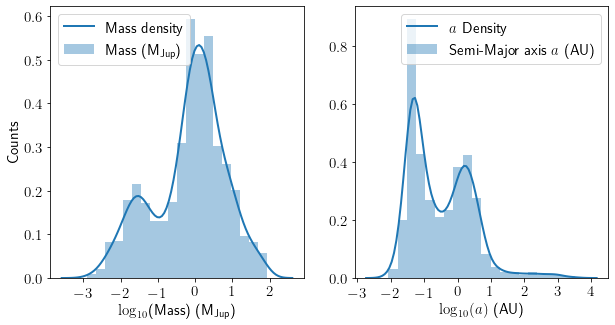

In [6]:
# -Plot----distributions 
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))

let, bins = 15, 20

m=np.log10(data.mass.values)
a=np.log10(data.semi_major_axis.values)

ax1 = sb.distplot(m, ax=ax1, bins=bins, label=r'Mass (M$_\text{Jup}$)',
                  kde_kws={"lw": 2, "label": r"Mass density"})

ax2 = sb.distplot(a, ax=ax2, bins=bins,label=r'Semi-Major axis $a$ (AU)',
                  kde_kws={"lw": 2, "label": r"$a$ Density"})

ax1.set_xlabel(r"$\log_{10}$(Mass) (M$_\text{Jup}$)",fontsize=let)
ax2.set_xlabel(r"$\log_{10}(a)$ (AU)",fontsize=let)
ax1.set_ylabel(r"Counts", fontsize=let)
ax1.tick_params(labelsize=let); ax2.tick_params(labelsize=let)

ax1.set_xticks(np.arange(int(min(m))-1, int(max(m))+2, 1.0))
ax2.set_xticks(np.arange(int(min(a))-1, int(max(a))+2, 1.0))


ax1.legend(loc='upper left',fontsize=let);ax2.legend(loc='upper right',fontsize=let)
#plt.savefig("figures/hists.pdf", bbox_inches='tight')

So, `data` is a DataFrame without NaN values in columns of names, masses, semi major axis and their uncertainties. Finally, we got 1217 rows, it means, exoplanets with confirmed data. 

## 2. Get the center of Mass 
We need to estimate the $r_\text{cm}$ for each system. The definition of center of mass:
\begin{equation*}
r_\text{cm} = \frac{\sum\limits_{k=1}^n(m_{k}\vec{r_{k}})}{\sum \limits_{k=1}^{n}m_{k}} %=\frac{\sum\limits_{k=1}^n(m_{k}\vec{r_{k}})}{M_{T}}
\end{equation*}
To do it, is nessesary get the values mass $m$ times disnace $r$, for each planet, so with the columns of `mass` and distance from the star `semi_major_axis` we can get $m_{k}\vec{r_{k}}$ values. Then, we take the sum for all planets in each systems, as a result we got $\text{CM}_i$ for $i\in\{0,1,2,3,4,\ldots,n\}$.

Our variable for clasify the systems is CM but some systems only have one planet, so, the center of mass for this systems CM$_j$, can be taked as the mass $m_j$.

**Remember:** The `data.groupby("key")` split the data in groups which are the key.

**Remember:** The `data[i].multiply(data[j])` multiplies the comun i and j of DataFrame or Series i and j, row by row.

**Remember:** The `data.groupby.groups.keys()` get the keys of the split data.

In [7]:
# Group by the name system:
p_system = data.groupby("star_name")
print('The number of planetary systems = '+ str(len(p_system)))

# The numer of exoplanets around each star:
number=(data["star_name"].value_counts()).to_frame()

# The number of systems with more than one exoplanet:
count = 0
for i, index in enumerate(number.star_name.values):
    if index>1.:
        count+=1 
print("Systems with more than one planet = "+str(count))

The number of planetary systems = 987
Systems with more than one planet = 154


In [8]:
#-----------------------function center of mass-----------------------
#it returns a data frame group bay systems:

def CoM(data): #data is a dataframe with mass and semi major axis 
    
    # Multiplications between columns mass and axis, CM_i new column:
    data = data.assign(CM_i=data["semi_major_axis"]*data["mass"])
    #print(data)
    # Group by each planet in the system:
    p_system = data.groupby("star_name") 
    system = list(p_system.groups.keys())
    # Total mass per system:
    M_total = p_system["mass"].sum()
    sum_rm = p_system['CM_i'].sum() # sum of masses in each system.
    # Center of mass:
    CoM = sum_rm.divide(M_total)
    
    system = list(p_system.groups.keys())
    
    NewData = pd.DataFrame({'System_name':system,
                            'Total_mass':M_total.tolist(),
                            'Center_of_Mass':CoM.tolist()})

    return NewData

CoM=CoM(data);#CoM

Therefore, the distribution of the $r_\text{cm}$

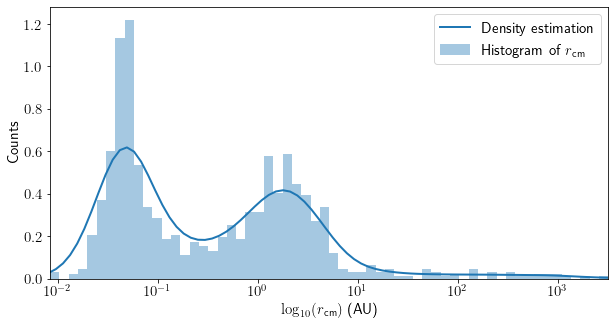

In [9]:
#histogram 
lat=15

x=CoM.Center_of_Mass.values

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax = sb.distplot(np.log10(x), bins=60, label=r"Histogram of $r_\text{cm}$",
                kde_kws={"lw": 2, "label": r"Density estimation"})

ax.set_xticklabels([r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'$10^{0}$',
                    r'$10^{1}$',r'$10^{2}$',r'$10^{3}$'])#,
#                    r'$10^{3}$',r'$10^{4}$'])

ax.set(xlim=(np.log10(x).min(),np.log10(x).max()))

plt.xlabel(r"$\log_{10}(r_\text{cm})$ (AU)", fontsize=lat)
plt.ylabel(r"Counts", fontsize=lat)
ax.tick_params(labelsize=lat)
plt.legend(fontsize=lat)
#plt.savefig("figures/CMhist.pdf",bbox_inches='tight')

However, the calculus of the $r_\text{cm}$, was made without take into account the mass of the star.

## 3. Gaussian Mixture Model

At first we will use the Gaussian Mixture Model to clasify the $r_\text{cm}$ in $n$ finite distributions. Python has the library `sckit-learn`, which uses the Expectation Maximization algorithm to determine the maximum likelihood for  a determined number $n$ of clusters (more informtion  <a href="https://scikit-learn.org/stable/modules/mixture.html">Gaussian Mixture</a>). 


### Class: Classification

We use the `GaussianMixture` package from `sckit-learn` to classify our data in different clusrers ($n$). Here, we employ the number of compnents, `n_components` as the numer of clusters $n$. We also use criteria to determine the ideal number of clusters. To do that we implement oriented programming language. 

In [80]:
# data is a DataFrame with the previous column Center_of_Mass.
# if log=True, it will take the log_10 of the variable in the DataFrame. 

class classification:

    def __init__(self, data, log=False):
        if log==True:
            self.data=np.reshape(np.log10(data.Center_of_Mass.values),(-1,1))
            self.name=r'$\log_{10}(r_\text{cm})$ [AU]'
        else: 
            self.data=np.reshape(data.Center_of_Mass.values,(-1,1))
            self.name=r'$r_\text{cm}$ [AU]'
    
    def GMM(self, n_components):
        self.n = n_components
        self.gmm = GaussianMixture(self.n, covariance_type='full', random_state=0)
        self.gmm.fit(self.data)
        self.cluster_label = self.gmm.predict(self.data)
        
    def inf_criteria(self, times):
        self.bic, self.aic = [], []
        for i in range(times):
            i += 1
            self.GMM(i)
            self.bic.append(self.gmm.bic(self.data)); self.aic.append(self.gmm.aic(self.data))
    
        print('Ideal number of clusters, BIC = '+str(self.bic.index(min(self.bic))+1))
        print('Ideal number of clusters, AIC = '+str(self.aic.index(min(self.aic))+1))

In [82]:
AA = classification(CoM, True)
AA.inf_criteria(30)

Ideal number of clusters, BIC = 4
Ideal number of clusters, AIC = 11


In [28]:
# "data" is a data frame with a Center_of_Mass. 
# "times" is the number of clusters in the criteria: AIC and BIC

def inf_criterion(times, data, log=False):
    
    bic, aic = [], []
    
    if log==True:
        x = np.reshape(np.log10(data.Center_of_Mass.values), (-1,1))
    else:
        x = np.reshape(data.Center_of_Mass.values, (-1,1))
    
    for i in range(times):
        i += 1
        gmm = GaussianMixture(i, covariance_type='full', random_state=0)
        gmm.fit(x)
        bic.append(gmm.bic(x)); aic.append(gmm.aic(x))
    
    criteria = [bic,aic]  
    min_criteria = [min(criteria[0])/max(criteria[0]),min(criteria[1])/max(criteria[1])]
    
    print('Ideal number of clusters, BIC = '+str(criteria[0].index(min(criteria[0]))+1))
    print('Ideal number of clusters, AIC = '+str(criteria[1].index(min(criteria[1]))+1))   
    
    return criteria

In [29]:
b = inf_criterion(15, CoM, False)

Ideal number of clusters, BIC = 6
Ideal number of clusters, AIC = 15


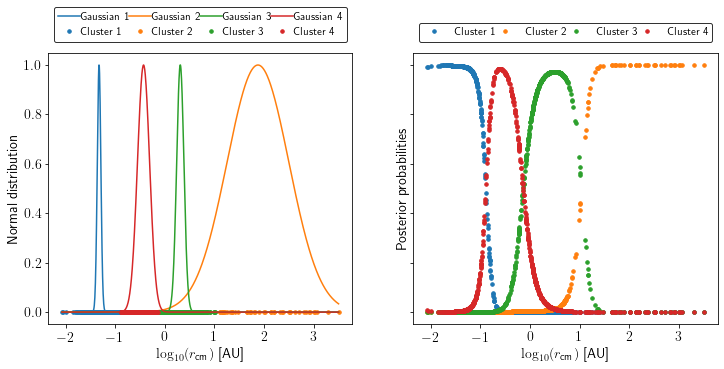

In [26]:
AA = classification(CoM, True)
AA.GMM(4)
AA.clusters_plot(True,"GMM-4")

In [27]:
"""
    #Clusters_plot
    def clusters_plot(self, save=False, fig_name="nn"):
        self.fig_name = fig_name
        dsize, lsize, fsize = 3.5, 11, 14
        self.color = ["C"+str(self.cluster_label[i]+1) for i in range(len(self.cluster_label))]
        x = np.linspace(self.data.min(),self.data.max(),1000)
        figure, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(12, 5))
        
        #Gaussians and scaters:
        for c in range(self.n):
            ax[0].plot(x,norm.pdf(x,self.gmm.means_[c], self.gmm.covariances_[c])[0]/\
                       norm.pdf(x,self.gmm.means_[c], self.gmm.covariances_[c])[0].max(), 
                      label =r"Gaussian "+str(c+1))
            
            Mass_a=self.data[self.cluster_label==c]    
            
            ax[0].plot(Mass_a, np.zeros(len(Mass_a)),"o", markersize=dsize,
                       label='Cluster '+str(c+1), color="C"+str(c))

            ax[1].plot(self.data,self.gmm.predict_proba(self.data)[:,c],"o",
                       markersize=dsize, label="Cluster "+str(c+1))
            
        ax[0].set(ylabel=r'Normal distribution', xlabel=self.name)
        ax[1].set(ylabel=r'Posterior probabilities',  xlabel=self.name)

        ax[0].legend(bbox_to_anchor=(0,1.02,1,0.2),loc="lower left", handletextpad=.01,
                     edgecolor='black', mode="expand", ncol=self.n, fontsize=lsize)
        ax[1].legend(bbox_to_anchor=(0,1.02,1,0.2),loc="lower left", 
                     mode="expand", ncol=self.n, fontsize=lsize, edgecolor='black') 
        
        plt.rcParams.update({'font.size': fsize})
        plt.subplots_adjust(wspace = .2)
        
        if save == True: 
            plt.savefig("figures/"+self.fig_name+".pdf" ,bbox_inches='tight')
"""

'\n    #Clusters_plot\n    def clusters_plot(self, save=False, fig_name="nn"):\n        self.fig_name = fig_name\n        dsize, lsize, fsize = 3.5, 11, 14\n        self.color = ["C"+str(self.cluster_label[i]+1) for i in range(len(self.cluster_label))]\n        x = np.linspace(self.data.min(),self.data.max(),1000)\n        figure, ax = plt.subplots(1, 2, sharex=\'col\', sharey=\'row\', figsize=(12, 5))\n        \n        #Gaussians and scaters:\n        for c in range(self.n):\n            ax[0].plot(x,norm.pdf(x,self.gmm.means_[c], self.gmm.covariances_[c])[0]/                       norm.pdf(x,self.gmm.means_[c], self.gmm.covariances_[c])[0].max(), \n                      label =r"Gaussian "+str(c+1))\n            \n            Mass_a=self.data[self.cluster_label==c]    \n            \n            ax[0].plot(Mass_a, np.zeros(len(Mass_a)),"o", markersize=dsize,\n                       label=\'Cluster \'+str(c+1), color="C"+str(c))\n\n            ax[1].plot(self.data,self.gmm.predict_pr

In [ ]:
"""#comparison between AIC and BIC criteria----------------(plot)------------------------

def plot_criteria(criteria):
  
    figure, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(9, 4))
    let   = 15 
    label = ['BIC','AIC']

    for i,criterium in enumerate(criteria):
        dim  = len(criteria[i])
        norm = min(criteria[i])/max(criteria[i])
        
        ax[i].plot(range(1, dim+1), criteria[i]/max(criteria[i]), "o",
                   c="C1",label=label[i]+" values")
        ax[i].plot(range(1, dim+1),criteria[i]/max(criteria[i]))#, label=label[i])
        ax[i].plot(range(1, dim+1),np.ones(dim)*norm,
                   "--",label=r"Ideal clusters "+str(criteria[i].index(min(criteria[i]))+1) )

        ax[i].set_xlabel(r'Number of clusters', fontsize=let+1)
        ax[i].legend(fontsize=let, loc=1,edgecolor='black')
        ax[i].set_xlim(0, dim+1)
        ax[i].set_xticks(np.arange(0, dim, step=2))
        ax[i].tick_params(labelsize=let)

    ax[0].set_ylabel(r'Criterium value normalized', fontsize=let+1)
    return [bic,aic]"""

### Function: Information Criterion AIC/BIC
Now, we need to determine the idel number of clusters. To do that, we use the information criterion as strategy to avoiding underfit or overfit. The information criteria determine the quality of models and score them (more information <a href="https://en.wikipedia.org/wiki/Model_selection#Criteria">Model selection</a>).  


We define a function wich gets the information criteria for different numbers of components (the number of mixture components $n$), in order to obtain the minimum value of criterium to determine the ideal number of clsuters. The lowest BIC/AIC is preferred.

Then, it plots the BIC and AIC values to observe their behavior.

In [ ]:
# "data" is a data frame with a Center_of_Mass. 
# "times" is the number of clusters in the criteria: AIC and BIC

def inf_criterion(times, data, log=False):
    
    bic, aic = [], []
    
    if log==True:
        x = np.reshape(np.log10(data.Center_of_Mass.values), (-1,1))
    else:
        x = np.reshape(data.Center_of_Mass.values, (-1,1))
    
    for i in range(times):
        i += 1
        gmm = GaussianMixture(i, covariance_type='full', random_state=0)
        gmm.fit(x)
        bic.append(gmm.bic(x)); aic.append(gmm.aic(x))
    
    criteria = [bic,aic]  
    min_criteria = [min(criteria[0])/max(criteria[0]),min(criteria[1])/max(criteria[1])]
    
    print('Ideal number of clusters, BIC = '+str(criteria[0].index(min(criteria[0]))+1))
    print('Ideal number of clusters, AIC = '+str(criteria[1].index(min(criteria[1]))+1))   
    
    return criteria

In [ ]:
Z

The ideal numer of cluster to group the center of mass $r_\text{cm}$ is determined through:  

In [ ]:
b = inf_criterion(15, CoM, False)
b_plot = plot_criteria(b)

The ideal numer of cluster to group the logarithm of the center of mass $r_\text{cm}$ is determined through: 

In [ ]:
a = inf_criterion(15, CoM, log=True)
a_plot = plot_criteria(a)

### Function: Fraction changed
This function generates 1000 synthetic systems ( _Dawns_ ) per each data (the mass an its uncertainty). We take draws from this, and stimate the validation of the classification.

The posteriror probabilities are determinated by the function `gmm.predict()`

In [ ]:
def fraction_changed(data, dawns):
    
    p_system    = data.groupby("star_name")
    system_list = list(p_system.groups.keys())
    draws       = [] #draws of COM for each system. 
    
    for i in range(len(system_list)):
        
        system_i      = data[data.star_name == system_list[i]]  
        system_i_mass = np.zeros(dawns)
        cm_i          = np.zeros(dawns) 
        
        for k in range(len(system_i)):
            masses = np.random.normal(system_i.mass.values[k],
                                      system_i.mass_error_min.values[k],
                                      dawns)
            axes = np.random.normal(system_i.semi_major_axis.values[k],
                                    system_i.semi_major_axis_error_min.values[k],
                                    dawns)
            cm_i          += masses*axes
            system_i_mass += masses
        #draws.append([np.abs(cm_i/system_i_mass)]
        draws.append([cm_i/system_i_mass])
    draws = np.array(draws)
    draws = draws[draws>0]
    return draws
        

In [ ]:
frc = fraction_changed(data,1000)
len(frc)

In [ ]:
from scipy.stats import truncnorm
a=0.1
b=2
x = np.linspace(truncnorm.ppf(0.01, a, b), 
                truncnorm.ppf(0.99, a, b), 
                100)
#print(x)
#plt.plot(truncnorm.ppf(x,a,b),x)

#r = truncnorm.rvs(a, b, size=1000)
#len(r)

In [ ]:
#list(p_system.groups.keys())

In [ ]:
system_list = list(p_system.groups.keys())
len(system_list)

In [ ]:
data[data.star_name == list(p_system.groups.keys())[i]]

In [ ]:
list(p_system.groups.keys())[1]

In [ ]:
#'dawns' is the number of synthetic systems per each data known
#'data' is a DataFrame of the data, with column "Center of Mass"
#'n_components' is the number of clusters for the lowest BIC/AIC.

def fraction_changed(n_components, dawns, data, log=False):
    
    draws=[]

    #1000 draws per planetary mass or systrem mass
    
    for i in range(len(data.values)):
        masses=np.random.normal(data.mass.values[i],
                                data.mass_error_min.values[i],
                                dawns)
        masses = masses[masses>0]
        draws += [masses]

    if log==True:
        mass = np.log10(data[["mass"]])
        draws = [np.log10(i) for i in draws]
        
    else:
        mass = data[["mass"]]
     
    #Gausian mixture model for masses  data:  
    gmm = GaussianMixture(n_components,covariance_type='full',random_state=0)
    gmm.fit(mass.values)
    cluster_label = gmm.predict(mass.values)
         
    #fraction of the synthttic systems wich change classification group:
    fraction_changed = []
    
    #to get only the posotice values of the draws, just get tyhe positives values: 
    #draws = [i for i in draws if i > 0] or None
    
    for index in range(len(draws)):
        #draw_i=np.abs(draws[index][:,np.newaxis])
        draw_i=draws[index][:,np.newaxis]
        orig=gmm.predict(np.array(mass))[index]
        fraction_changed+=[(orig!=gmm.predict(draw_i)).sum()/1000]
    lid=[len(i) for i in draws]
    #print( np.min(lid),np.mean(lid) )
    return(draws)
    #return((np.array(fraction_changed)<=0.1).sum()/len(fraction_changed))
    #return fraction_changed

In [ ]:
#frac_mass=fraction_changed(4,1000,CoM[["Center_of_Mass"]],False)

In [ ]:
#np.log10(data[["Center_of_Mass"]])==np.log10(CoM[["Center_of_Mass"]])

In [ ]:
#GaussianMixture:  a firs approximation for 10 grups
#----------------------------------------------------------------------
data = CoM
gmm = GaussianMixture(1, covariance_type='full', random_state=0)
CM=CoM[["Center_of_Mass"]]
gmm.fit(CM.values)
cluster_label = gmm.predict(CM.values)
plt.scatter((CM.values),np.zeros(len(CM)), c=cluster_label);
plt.ylim(-0.1,0.1)
plt.xlabel(r"Center Of Mass (AU)", fontsize="15")
#For the CoM is nessesary emply a Logarithm sclae.

In [ ]:
#the log10scale for center of mass of each exoplanetary system:
#----------------------------------------------------------------------
CM_log=np.log10(data[["Center_of_Mass"]])

GMM,cluster=[],[]

#Some different components for Gaussian Mixture Model: 
#----------------------------------------------------------------------
for i in [2,3]:
    gmm = GaussianMixture(i, covariance_type='full', random_state=0)
    GMM.append(gmm)
    gmm.fit(CM_log.values)
    cluster_label = gmm.predict(CM_log.values)
    cluster.append(cluster_label)

# (just a plot for two grups)
#----------------------------------------------------------------------
#plt.rc('text', usetex=True)

color=[]
#len(cluster[0])
for i in range(len(cluster[0])):
    if cluster[0][i] == 0:
        color.append("C1")
    elif cluster[0][i] == 1:
        color.append("C2")

x=np.linspace(-2.5,4,1000)
colors=["C1","C2","C3","C4","C5"]

fig, ax1 = plt.subplots(1, 1, sharex='col', sharey='row')

plt.gcf().subplots_adjust(bottom=0.15,right=0.96, left=0.115, top=0.93)

for i, (v1,v2) in enumerate(zip(GMM[0].means_,GMM[0].covariances_)):
    ax1.plot(x, norm.pdf(x,v1,v2)[0]/norm.pdf(x,v1,v2)[0].max(),
             c=colors[i],label="Cluster "+str(i+1))
    ax1.legend(fontsize=15,edgecolor='black')

ax1.scatter((CM_log.values),np.zeros(len(CM_log)),c=color, 
            label="Cluster",s=10)  

ax1.tick_params(labelsize=19)

plt.xlabel(r'$\log_{10}$(CM)',fontsize=20)
plt.ylabel(r'Normal Distribution',fontsize=20)
plt.savefig("figures/GMM1.pdf")

In [ ]:
# (just a plot for five grups)
#----------------------------------------------------------------------
color=[]
C = cluster[1]
for i in range(len(cluster[1])):
    if C[i] == 0:
        color.append("C1")
    elif C[i] == 1:
        color.append("C2")
    elif C[i] == 2:
        color.append("C3")
    elif C[i] == 3:
        color.append("C4")
    elif C[i] == 4:
        color.append("C5")

x=np.linspace(-2.5,4,1000)
colors=["C1","C2","C3","C4","C5"]

fig2, ax2 = plt.subplots(1, 1, sharex='col', sharey='row')

plt.gcf().subplots_adjust(bottom=0.17,right=0.97, left=0.175, top=0.90)

for i, (v1,v2) in enumerate(zip(GMM[1].means_,GMM[1].covariances_)):
    ax2.plot(x, norm.pdf(x,v1,v2)[0]/norm.pdf(x,v1,v2)[0].max(),
             c=colors[i],label="Cluster "+str(i+1))
    ax2.legend(fontsize=14, loc=1,edgecolor='black')

ax2.scatter((CM_log.values),np.zeros(len(CM_log)),c=color, label="Group 1")  
ax2.set_xlim(-2.3,5.2)

ax2.tick_params(labelsize=19)

#plt.title(r"GMM with three components",fontsize=22)
plt.xlabel(r'$\log_{10}$(CM)',fontsize=20)
plt.ylabel(r'Normal Distribution',fontsize=20)
#plt.savefig("figures/GMM3.pdf")

In [ ]:
#Some different components for Gaussian Mixture Model: 
data = CoM
CM_log=np.log10(data[["Center_of_Mass"]])
GMM,cluster=[],[]
let=16
#----------------------------------------------------------------------
for i in [4,6]:
    gmm = GaussianMixture(i, covariance_type='full', random_state=0)
    GMM.append(gmm)
    gmm.fit(CM_log.values)
    cluster_label = gmm.predict(CM_log.values)
    cluster.append(cluster_label)
#----------------------------------------------------------------------
col=[]

for i in range(len(cluster[0])):
    if cluster[0][i] == 0:
        col.append("C1")
    elif cluster[0][i] == 1:
        col.append("C2")
    elif cluster[0][i] == 2:
        col.append("C3")
    elif cluster[0][i] == 3:
        col.append("C4")

lor=[]
C = cluster[1]
for i in range(len(cluster[1])):
    if C[i] == 0:
        lor.append("C1")
    elif C[i] == 1:
        lor.append("C2")
    elif C[i] == 2:
        lor.append("C3")
    elif C[i] == 3:
        lor.append("C4")
    elif C[i] == 4:
        lor.append("C5")  
    elif C[i] == 5:
        lor.append("C6") 
    elif C[i] == 6:
        lor.append("C7")
        
x=np.linspace(-2.5,4,1000)
colors=["C1","C2","C3","C4","C5","C6","C7"]

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

plt.gcf().subplots_adjust(bottom=0.12,right=0.99, left=0.07, top=0.88)

#axs[0].scatter((CM_log.values),np.zeros(len(CM_log)),c=col)  
#axs[1].scatter((CM_log.values),np.zeros(len(CM_log)),c=lor)  

#h1 = axs[0].hist(CM_log.values,60, density=True)#,label=r"Histogram of $r_\text{cm}$")

sb.distplot(CM_log.values,60,kde=False, norm_hist=True, ax = axs[0])#,label=r"Histogram of $r_\text{cm}$")    
sb.distplot(CM_log.values,60,kde=False, norm_hist=True, ax = axs[1])#,label=r"Histogram of $r_\text{cm}$")    
    
#leg1 = plt.legend(loc='upper left', fontsize=let-5)

#izq
for i, (v1,v2) in enumerate(zip(GMM[0].means_,GMM[0].covariances_)):
    axs[0].plot(x, norm.pdf(x,v1,v2)[0]/norm.pdf(x,v1,v2)[0].max(),
             c=colors[i],label="Cluster "+str(i+1),lw=2.5)
    axs[0].legend(fontsize=let-2,edgecolor='black',bbox_to_anchor=(-0, 1.02, 1, .15), loc=3,
              ncol=2,mode="expand")
#der
for i, (v1,v2) in enumerate(zip(GMM[1].means_,GMM[1].covariances_)):
    axs[1].plot(x, norm.pdf(x,v1,v2)[0]/norm.pdf(x,v1,v2)[0].max(),
             c=colors[i],label="Cluster "+str(i+1),lw=2.5)
    axs[1].legend(fontsize=let-2,edgecolor='black',bbox_to_anchor=(0, 1.02, 1, .102), loc=3,
              ncol=3, mode="expand")
    
axs[0].set_ylim(-0.1,1.4,1/10)
axs[0].set_xlim(CM_log.values.min(),CM_log.values.max())
axs[1].set_xlim(CM_log.values.min(),CM_log.values.max())
#axs[0].set_xscale('log')
axs[0].tick_params(labelsize=let)
axs[1].tick_params(labelsize=let)

plt.subplots_adjust(wspace=0.05)

#axs.xlabel(r'$\log_{10}$(CM)',fontsize=20)
axs[0].set_ylabel(r'Normal Distribution',fontsize=let)
fig.text(0.53, 0.0, r"$\log_{10}(r_\text{cm})$ (AU)", 
         fontsize=let, ha='center', va='center')

fig.text(.355, .8, r"Histogram of $r_\text{cm}$", color='k',
         fontsize=let, bbox=dict(facecolor="C0",alpha = .4))

fig.text(.825, .8, r"Histogram of $r_\text{cm}$", color='k',
         fontsize=let, bbox=dict(facecolor="C0",alpha = .4))
#plt.gca().add_artist(leg1)

#plt.savefig("figures/GMM_2-3-hist.pdf",bbox_inches='tight')
plt.savefig("figures/GMM_4-6-hist.pdf",bbox_inches='tight')


To determine the number of cluster in the Gaussian Mixture Model, it may use a bayessian information criterion

In [ ]:
#Bayesian information criterion 
CM_log=np.log10(data[["Center_of_Mass"]])
print(CM_log)
bic,aic = [],[]
tries=16

for i in range(tries):
    i+=1
    gmm = GaussianMixture(i, covariance_type='full', random_state=0)
    CM_log=np.log10(data[["Center_of_Mass"]])
    gmm.fit(CM_log.values)
    bic+=[gmm.bic(CM_log.values)]
    aic+=[gmm.aic(CM_log.values)]
#bic
# (just a plot to bayessian criterion)
#----------------------------------------------------------------------

#fig = plt.figure(figsize=(4,3))
#plt.plot(range(1,11),bic)

let=17
names=[r"Normal BIC",r"Normal AIC"]
criteria = [bic, aic]

x=range(1,tries+1)

fig, axs = plt.subplots(1, 2, figsize=(11, 5))#, sharex=True)# sharex='col', sharey='row')
plt.gcf().subplots_adjust(bottom=0.12,right=0.99, left=0.07, top=0.88)

for i in range(len(criteria)):
    y=criteria[i]/max(criteria[i])
    h = axs[i].plot(x,y, lw="2")
    f = axs[i].plot(x,y, "o", c="C1",label=names[i],markersize=4)
    
    g = axs[i].plot(x,np.ones(len(criteria[i]))*min(criteria[i])/max(criteria[i]),"--")

    axs[i].set_ylim(.71,1.01)
    axs[i].set_xlim(0,tries+1)
    axs[i].tick_params(labelsize=let)
    axs[i].legend(fontsize=let, loc=1,edgecolor='black')
    #axs[i].set_yticks(range(0,1),.1)
    axs[i].set_ylabel(names[i],fontsize=let)
    axs[i].set_xticks(np.arange(min(x), max(x)+1, 3.0))
    
fig.text(0.53, 0.0, r'Number of Clusters', fontsize=let+2, ha='center', va='center')
fig.tight_layout(pad=2.0)
    
#plt.title(r"Bayessian Information Criterion",fontsize=16)
#plt.xlabel(,fontsize=let)
plt.savefig("figures/BIC-AIC.pdf",bbox_inches='tight')

In [ ]:
criteria

In [ ]:
print(bic.index(min(bic))+1,aic.index(min(aic))+1)

In [ ]:
# GaussianMixture, for the log of CM: 
# 4 groups due tu the bic
gmm = GaussianMixture(4, covariance_type='full', random_state=0)
CM_log=np.log10(data[["Center_of_Mass"]])
gmm.fit(CM_log.values)
cluster_label = gmm.predict(CM_log.values)
plt.scatter((CM_log.values),np.zeros(len(CM_log)),c=cluster_label);
plt.ylim(-0.1,1)

In [ ]:
cluster_label[794]

The probabilities or verisimilitudes, are defined by normal distribution for each group from the gaussian mixture model:

In [ ]:
#gmm.means_
#just a plot to bayessian criterion for 4 clusters 
#----------------------------------------------------------------------
plt.figure(figsize=(15,7))
plt.gcf().subplots_adjust(bottom=0.15,right=0.96, left=0.08, top=0.93)

color=[]
CL = cluster_label
for i in range(len(cluster[1])):
    if CL[i] == 0:
        color.append("C1")
    elif CL[i] == 1:
        color.append("C2")
    elif CL[i] == 2:
        color.append("C3")
    elif CL[i] == 3:
        color.append("C4")
    elif CL[i] == 4:
        color.append("C5")
        
colors=["C1","C2","C3","C4","C5"]

#fig4, ax4 = plt.subplots(1, 1, sharex='col', sharey='row')

for i, (v1,v2) in enumerate(zip(gmm.means_,gmm.covariances_)):
    plt.plot(x, norm.pdf(x,v1,v2)[0]/norm.pdf(x,v1,v2)[0].max(),
             c=colors[i],label="Cluster "+str(i+1),lw=2)
    plt.legend(fontsize=24, loc=1,edgecolor='black')

plt.scatter((CM_log.values),np.zeros(len(CM_log)),c=color, label="Group 1")  
#plt.hist(CM_log.values,100, density=True)

plt.xlim(-2.2,3.7)

plt.tick_params(labelsize=24)

plt.title(r"GMM for the BIC clusters",fontsize=25)
plt.xlabel(r'$\log_{10}$(CM)',fontsize=26)
plt.ylabel(r'Normal Distribution',fontsize=26)
#plt.savefig("figures/GMM4.pdf") 

The posteriror probabilities are determinated by the function `gmm.predict_proba()`

In [ ]:
# The posterior probabilities: 
names=["Earth-centered", "Close","Far away","Venusian-centered"]
plt.figure(figsize=(7,5.6))

for i in range(4):
    plt.scatter(CM_log,gmm.predict_proba(CM_log)[:,i],label=names[i], s=7);

plt.gcf().subplots_adjust(bottom=0.15,right=0.97, left=0.15, top=0.83)
plt.tick_params(labelsize=20)    
plt.xlabel(r'$\log_{10}(r_\text{cm}) \text{(AU)}$',fontsize=22)
plt.ylabel(r'Posterior Probabilities',fontsize=22)
plt.xlim(-2.5,4)

plt.xticks(np.arange(int(min(m)), int(max(m))+2, 1.0))

plt.legend(fontsize=17.5,edgecolor='black', 
           bbox_to_anchor=(-0.02, 1.20, 1.037, 0.06), loc=2,
           ncol=2, mode="expand")
plt.savefig("figures/Prob.pdf")

In [ ]:
gmm.predict_proba(CM_log)[794]
CM_log.values[794]

The probability for a synthetic draw of a system called AA, with a $\mu=0.8$ and $\sigma=0.03$ in the CM, can be established as:

In [ ]:
AA=np.log10(np.random.normal(0.8,0.03,1000))
AA=AA[:,np.newaxis]
names=["Earth-centered", "Close","Far away","Venusian-centered"]
plt.figure(figsize=(7,5.6))

#production of probability for a syntethic planetary system 
for i in range(4):
    plt.scatter(AA,gmm.predict_proba(AA)[:,i],label=names[i])

plt.gcf().subplots_adjust(bottom=0.15,right=0.965, left=0.14, top=0.83)
plt.legend(fontsize=17.5,edgecolor='black', 
           bbox_to_anchor=(-0.02, 1.20, 1.037, 0.055), loc=2,
           ncol=2, mode="expand")
plt.tick_params(labelsize=20)    
plt.xlabel(r'$\log_{10}$(CM)',fontsize=22)
plt.ylabel(r'Probability',fontsize=22)
#plt.savefig("figures/draw.pdf")

In [ ]:
AA

## ... Draws
Employing m and $\Delta$m, a and $\Delta$a, from `data2`.

In [ ]:
# Group the planetary system:
data2 = dataB[['star_name','mass', 'mass_error_min',
               'semi_major_axis','semi_major_axis_error_min']]
Planetary_System = data2.groupby("star_name")
Systems_List = list(Planetary_System.groups.keys())

A first way to get the drows for each system:

In [ ]:
#%%time
#-------------------------------------------------------------------------
# Draws, for each planetary system
draws=[]#drows of COM for each system. 
for i in range(len(Systems_List)):
    system_i = data2[data2.star_name == Systems_List[i]]    
    draw_i=[]
    for j in  range(1000):
        #Get random values for each planet in a system and the COM for those values
        masses=np.random.normal(system_i.mass,system_i.mass_error_min)
        axes=np.random.normal(system_i.semi_major_axis,
                              system_i.semi_major_axis_error_min)
        draw_i += [(masses*axes).sum()/masses.sum()]
    draws.append(draw_i)


In [ ]:
#len(draws[0])

Second way to get the draws for each system (in a shorter time):

In [ ]:
#%%time
DrawsA=[]#drows of COM for each system. 
for i in range(len(Systems_List)):
    SystemA_i = data2[data2.star_name == Systems_List[i]]  
    Mass_System = np.zeros(1000)
    Mass_Axe = np.zeros(1000) 
    for k in range(len(SystemA_i)):
        Masses = np.random.normal(SystemA_i.mass.values[k],
                                  SystemA_i.mass_error_min.values[k],1000)
        Axes = np.random.normal(SystemA_i.semi_major_axis.values[k],
                                SystemA_i.semi_major_axis_error_min.values[k],
                                1000)
        Mass_Axe += Masses*Axes
        Mass_System += Masses
        #print(SystemA_i.mass.values[k])
    DrawsA.append(np.abs(Mass_Axe/Mass_System))
len(DrawsA)

In [ ]:
Systems_List.index("TRAPPIST-1")

In [ ]:
Tras = DrawsA[Systems_List.index("TRAPPIST-1")]
fig, ax1 = plt.subplots(1, 1)

let=15

ax1 = sb.distplot(Tras, ax=ax1, bins=50, 
                  label=r' Synthetic $r_\text{cm}$ (AU)',
                  kde_kws={"lw": 2, "label": r" Synthetic density"})

ax1.set_xlabel(r"$\log_{10}$(Mass) (M$_\text{Jup}$)",fontsize=let)
#_xlabel(,fontsize=let);ax.set_ylabel(r"Orbital period (years)",fontsize=let)
ax1.set_ylabel(r"Distribution", fontsize=let)
ax1.tick_params(labelsize=let)


ax1.legend(loc='upper left',fontsize=let);
plt.savefig("figures/Tras_hists.pdf", bbox_inches='tight')

In [ ]:
#import seaborn as sns
#sns.set()
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

f1 = ax1.hist(DrawsA[2][0],10,alpha=0.8,label=Systems_List[2]+" DrawsA")
f2 = ax1.hist(draws[2],10, alpha=0.6,label=Systems_List[2]+" draws")
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=1, mode="expand", borderaxespad=0.)
f2 = sns.kdeplot(DrawsA[2][0], shade=True,label=Systems_List[2]+" DrawsA")
f3 = sns.kdeplot(draws[2], shade=True,label=Systems_List[2]+" draws")
ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=1, mode="expand", borderaxespad=0.)

The probability of each draw to belong a each group, taking draws form `DrawsA`

In [ ]:
kk=8
Draw_i=np.log10(DrawsA[kk][0][:,np.newaxis])
orig=gmm.predict(np.array(CM_log))[kk]
print(orig)
print((orig!=gmm.predict(Draw_i)).sum()/1000)
for i in range(4):
    plt.scatter(Draw_i,gmm.predict_proba(Draw_i)[:,i])

In [ ]:
np.log10(DrawsA[8])[0][:10]

In [ ]:
plt.hist(np.log10(DrawsA[8])[0])

In [ ]:
# CM_log is the centero of mass in log scale for each system
frac=[]
for kk in range(len(DrawsA)):
    Draw_i=np.log10(DrawsA[kk][0][:,np.newaxis])
    orig=gmm.predict(np.array(CM_log))[kk]
#    print(kk)
    frac+=[(orig!=gmm.predict(Draw_i)).sum()/1000] # AA es el elemento i de draws (que debe ser un array de 1000 elementos)


#for i in range(4):
#    plt.scatter(Draw_i,gmm.predict_proba(Draw_i)[:,i])
#orig
#AA
#orig=gmm.predict(np.array([[0.8]])) # 0.8 es el centro de masa para el sistema i
#(orig!=gmm.predict(AA)).sum()/1000 # AA es el elemento i de draws (que debe ser un array de 1000 elementos)
#DrawsA[0]
#Draw_i=DrawsA[0][0][:,np.newaxis]
#gmm.predict(Draw_i)
#Draw_i
#gmm.predict(Draw_i)
plt.hist(frac)
print((np.array(frac)==0).sum()/len(frac))
np.max(frac)

In [ ]:
orig=gmm.predict(np.array(CM_log))[2]
print(CM_log.values)
DrawsA[2][0]

#### Metallicity

In [ ]:
dataMet = data_ep[pd.notnull(data_ep["star_metallicity"])]
dataMetA = dataMet[pd.notnull(dataMet["star_metallicity_error_min"])]
dataMet = dataMetA[['star_name',"star_metallicity","star_metallicity_error_min"]]

In [ ]:
gmm2 = GaussianMixture(3, covariance_type='full', random_state=0)
B=dataMet[["star_metallicity"]]
gmm2.fit(B.values)
cluster_label = gmm2.predict(B.values)
B.values[:, 0]
plt.scatter((B.values),np.zeros(len(B)), c=cluster_label);
plt.ylim(-0.1,1)

In [ ]:
bic=[]
for i in range(15):
    i+=1
    gmm2 = GaussianMixture(i, covariance_type='full', random_state=0)
    A=data1[["center_of_Mass"]]
    gmm2.fit(B.values)
    bic+=[gmm2.bic(B.values)]
plt.plot(range(1,16),bic)

In [ ]:
plt.figure(figsize=(15,5))
sma=np.linspace(-2.5,4,1000)
for m,s in zip(gmm.means_,gmm.covariances_):
    plt.plot(sma, norm.pdf(sma,m,s)[0])
plt.scatter((A.values),np.zeros(len(A)), c = cluster_label);